Created by Zain Eris Kamal (zain.eris.kamal@rutgers.edu) on 5/17/23.

Purpose:
- Representative crustal thickness in Henry crater without layering.
    - Henry crater has layering, likely aeolian deposits, which bias Wieczorek's crustal thickness data (derived from topology minus moho).  
- Calculate the range of crustal thickness value at Henry crater with different interior models.

---
---
## 0. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import zerisk.Utils as utils

In [2]:
''' Load crater data '''

import zerisk.Craters

path__datahome = utils.getPath('current','..','data','1_raw')

Craters = zerisk.Craters.Craters()
Craters.downloadData(path__datahome, overwrite=False, verbose=True)

Craters.loadData(minDiam=70, maxDiam=1000, extraInfo=True)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\craters. 
To overwrite, add `overwrite=True` param.



In [3]:
''' Load crustal thickness data '''

import zerisk.Crust
Crust = zerisk.Crust.Crust()

path__datahome = utils.getPath('current','..','data','1_raw')
Crust.downloadData(path__datahome, overwrite=False, verbose=True)

Crust.loadData(spacing=0.1)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\crustal_thickness. 
To overwrite, add `overwrite=True` param.



---
---
## 1. Previous Work

### 1.1. Elevation

![](https://files.catbox.moe/tr7lso.png)

---
### 1.2. Wieczorek Crustal Thickness Map

In [78]:
def plot_craterCrThick_2D(identifier, scaling, spacing):

    if '-' in identifier:
        thiscrater = Craters.getByID(identifier)
    else:
        thiscrater = Craters.getByName(identifier)

    # thiscrater = Craters.getByName(crater_name)
    radius_th = Craters.km2theta(thiscrater['diam']/2)

    lon_left = thiscrater['lon']-radius_th*scaling
    lon_right = thiscrater['lon']+radius_th*scaling
    lat_bottom = thiscrater['lat']-radius_th*scaling
    lat_top = thiscrater['lat']+radius_th*scaling

    dat = []

    for lat in np.arange(lat_bottom, lat_top, spacing):
        newline = []
        for lon in np.arange(lon_left, lon_right, spacing):
            x = Crust.getThickness(lon, lat)
            newline.append(x)
        dat.append(newline)

        
    # dat = np.asarray(dat)
    # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)

    if thiscrater['name'] == '':
        name = thiscrater['id']
    else:
        name = thiscrater['name']

    ax.set_title(f'Crustal Thickness at {name}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.xaxis.set_major_formatter('{x}$\degree$')
    ax.yaxis.set_major_formatter('{x}$\degree$')

    cbar.set_label('Crustal Thickness (km)',y=0.5)

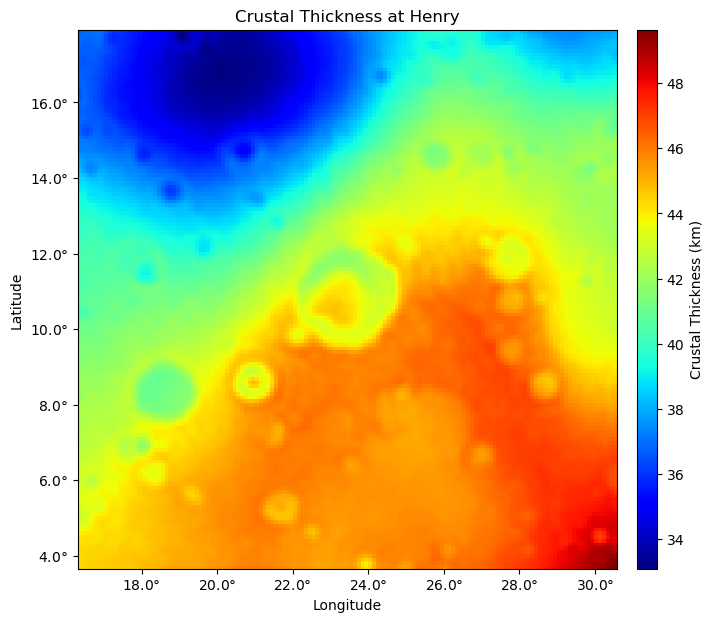

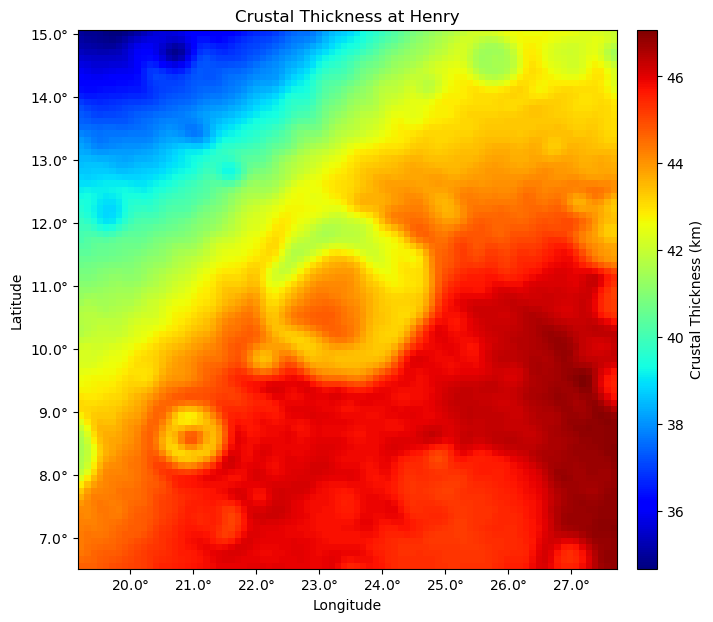

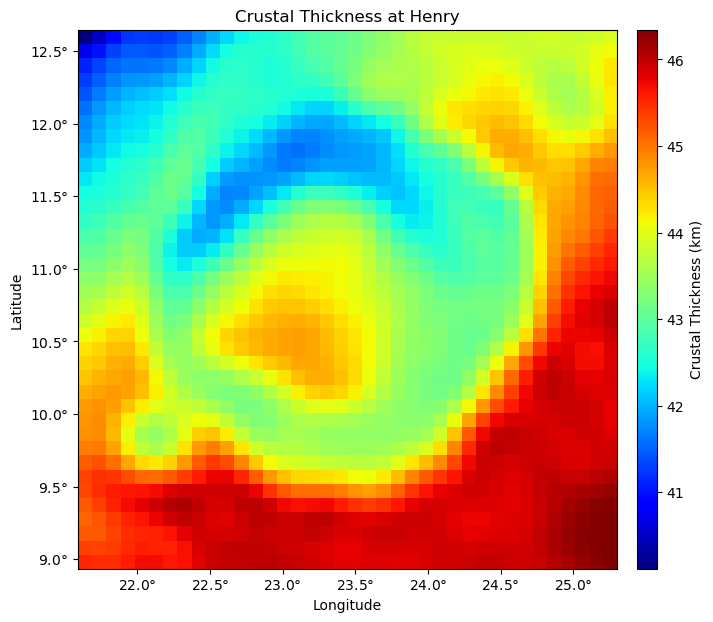

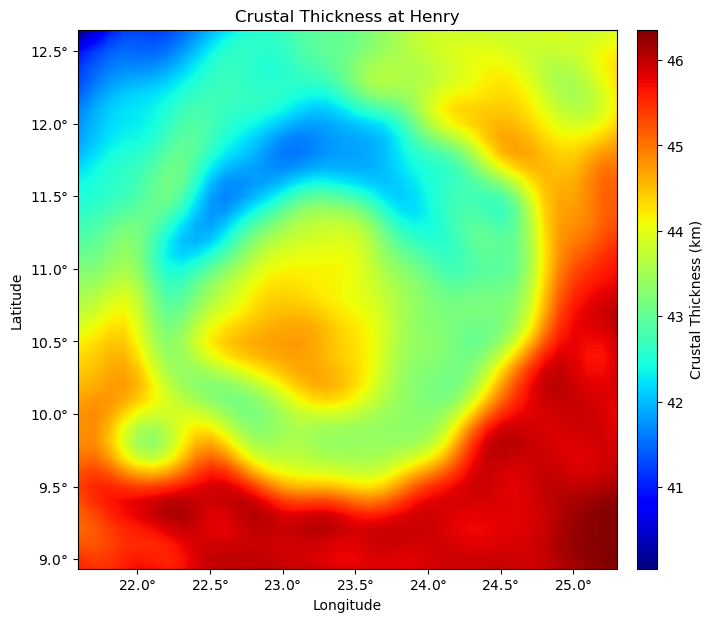

In [79]:
crater_name = 'Henry'
plot_craterCrThick_2D(crater_name, 5, 0.1)
plot_craterCrThick_2D(crater_name, 3, 0.1)
plot_craterCrThick_2D(crater_name, 1.3, 0.1)
plot_craterCrThick_2D(crater_name, 1.3, 0.01)

---
---
## 2. Crater Cross-Sections

### 2.1. Henry Cross-sections

Text(0, 0.5, 'Crustal Thickness [km]')

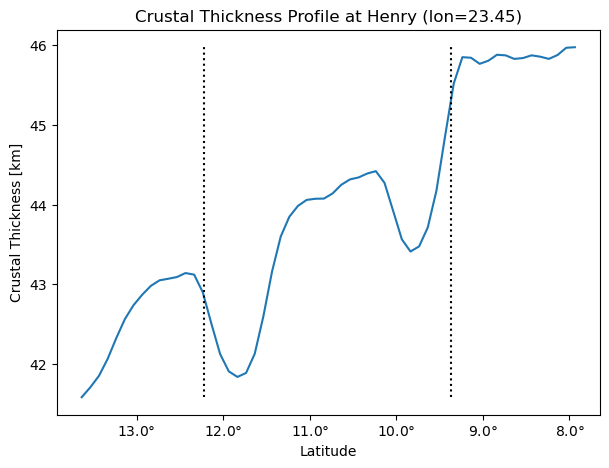

In [6]:
crater_name = 'Henry'
scaling = 2
spacing = 0.1


thiscrater = Craters.getByName(crater_name)
radius_th = Craters.km2theta(thiscrater['diam']/2)


lon = thiscrater['lon']
crater_lat_bottom = thiscrater['lat']-radius_th
crater_lat_top = thiscrater['lat']+radius_th
lat_bottom = thiscrater['lat']-radius_th*scaling
lat_top = thiscrater['lat']+radius_th*scaling


lat_range = np.arange(lat_bottom, lat_top, spacing)


dat = []

for lat in lat_range:
    dat.append(Crust.getThickness(lon, lat))

dat = np.asarray(dat)


fig = plt.figure(figsize=(7,5))
ax = plt.axes()
lin = ax.plot(lat_range, dat)

ax.invert_xaxis()

ax.vlines(x=[crater_lat_bottom, crater_lat_top], ymin=np.amin(dat), ymax=np.amax(dat), colors='k', linestyles='dotted')

ax.set_title(f'Crustal Thickness Profile at {crater_name} (lon={lon:0.2f})')
ax.set_xlabel('Latitude')
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.set_ylabel('Crustal Thickness [km]')

Text(0, 0.5, 'Crustal Thickness [km]')

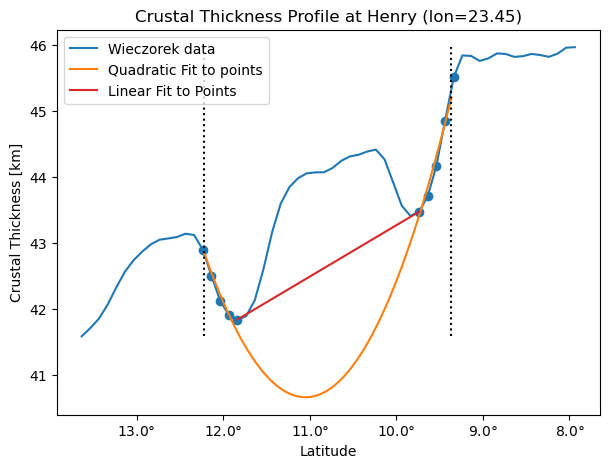

In [65]:
''' Get cross-sectional data '''

crater_name = 'Henry'
scaling = 2
spacing = 0.1


thiscrater = Craters.getByName(crater_name)
radius_th = Craters.km2theta(thiscrater['diam']/2)


lon = thiscrater['lon']
crater_lat_bottom = thiscrater['lat']-radius_th
crater_lat_top = thiscrater['lat']+radius_th
lat_bottom = thiscrater['lat']-radius_th*scaling
lat_top = thiscrater['lat']+radius_th*scaling


lat_range = np.arange(lat_bottom, lat_top, spacing)


dat = []

for lat in lat_range:
    dat.append(Crust.getThickness(lon, lat))

dat = np.asarray(dat)





''' Isolate un-altered crater data + fit '''

bounds = [9.25, 9.75, 11.8, 12.25]

ind = np.where((bounds[0] < lat_range) & (lat_range < bounds[1]) | (bounds[2] < lat_range) & (lat_range < bounds[3]))
lat_range_crop = lat_range[ind]
dat_crop = dat[ind]




from scipy.optimize import curve_fit

def model_f(x,a,b,c):
    return a*(x-b)**2 + c

popt, pcov = curve_fit(model_f, lat_range_crop, dat_crop, p0=[1,11,45])

a_opt, b_opt, c_opt = popt
x_model = np.linspace(crater_lat_bottom, crater_lat_top, 100)
y_model = model_f(x_model, a_opt, b_opt, c_opt)




''' Plot data and fit '''


fig = plt.figure(figsize=(7,5))
ax = plt.axes()

lin_dat, = ax.plot(lat_range, dat, color='C0')
lin_dat.set_label('Wieczorek data')

scat_training = ax.scatter(lat_range_crop, dat_crop, color='C0')

lin_quad_fit, = ax.plot(x_model, y_model, color='C1')
lin_quad_fit.set_label('Quadratic Fit to points')

left = np.abs(lat_range_crop-bounds[1]).argmin()
right = np.abs(lat_range_crop-bounds[2]).argmin()
lin_linear_fit, = ax.plot([lat_range_crop[left], lat_range_crop[right]], [dat_crop[left], dat_crop[right]], color='C3')
lin_linear_fit.set_label('Linear Fit to Points')

ax.legend()

ax.invert_xaxis()

ax.vlines(x=[crater_lat_bottom, crater_lat_top], ymin=np.amin(dat), ymax=np.amax(dat), colors='k', linestyles='dotted')

ax.set_title(f'Crustal Thickness Profile at {crater_name} (lon={lon:0.2f})')
ax.set_xlabel('Latitude')
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.set_ylabel('Crustal Thickness [km]')

In [50]:
# np.where(lat_range == np.amin(lat_range-bounds[1]))
print(lat_range)
left = np.abs(lat_range_crop-bounds[1]).argmin()
print(left)
print(lat_range_crop[left])

[ 7.93634903  8.03634903  8.13634903  8.23634903  8.33634903  8.43634903
  8.53634903  8.63634903  8.73634903  8.83634903  8.93634903  9.03634903
  9.13634903  9.23634903  9.33634903  9.43634903  9.53634903  9.63634903
  9.73634903  9.83634903  9.93634903 10.03634903 10.13634903 10.23634903
 10.33634903 10.43634903 10.53634903 10.63634903 10.73634903 10.83634903
 10.93634903 11.03634903 11.13634903 11.23634903 11.33634903 11.43634903
 11.53634903 11.63634903 11.73634903 11.83634903 11.93634903 12.03634903
 12.13634903 12.23634903 12.33634903 12.43634903 12.53634903 12.63634903
 12.73634903 12.83634903 12.93634903 13.03634903 13.13634903 13.23634903
 13.33634903 13.43634903 13.53634903 13.63634903]
4
9.736349031999994


### 2.2. Other Craters

In [8]:
Craters_170 = zerisk.Craters.Craters()
Craters_170.downloadData(path__datahome, overwrite=False, verbose=True)

Craters_170.loadData(minDiam=160, maxDiam=170, extraInfo=True)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\craters. 
To overwrite, add `overwrite=True` param.



In [9]:
Craters_170.getData()

,id,lon,lat,diam,clon,name,age,age_error
0,04-1-011014,-138.395328,-69.616440,161.631580,221.604672,,-1.0,-1.00
1,06-1-016483,-52.021828,3.188000,164.145307,307.978172,,-1.0,-1.00
2,04-1-000179,-157.637845,-45.888672,164.784138,202.362155,,-1.0,-1.00
3,06-0-001286,-7.943328,21.893648,165.239557,352.056672,,-1.0,-1.00
4,14-1-013251,125.423981,1.832644,165.964039,125.423981,,-1.0,-1.00
5,11-0-003866,1.637582,-18.236792,166.381127,1.637582,,-1.0,-1.00
6,03-1-013085,-140.307297,-23.231095,167.156500,219.692703,,-1.0,-1.00
7,12-1-000995,29.687773,-47.578795,167.313700,29.687773,,-1.0,-1.00
8,10-0-003901,23.445249,10.790610,167.581668,23.445249,Henry,3.6,0.03
9,16-1-009071,167.859945,-63.248822,168.782914,167.859945,,-1.0,-1.00


In [87]:
crater_name = 'Henry'
scaling = 2
spacing = 0.1


def plot_craterCrThick_crossSection(thiscrater, scaling, spacing):

    # if '-' in identifier:
    #     thiscrater = Craters.getByID(identifier)
    # else:
    #     thiscrater = Craters.getByName(identifier)

    radius_th = Craters.km2theta(thiscrater['diam']/2)


    lon = thiscrater['lon']
    crater_lat_bottom = thiscrater['lat']-radius_th
    crater_lat_top = thiscrater['lat']+radius_th
    lat_bottom = thiscrater['lat']-radius_th*scaling
    lat_top = thiscrater['lat']+radius_th*scaling


    lat_range = np.arange(lat_bottom, lat_top, spacing)


    dat = []

    for lat in lat_range:
        dat.append(Crust.getThickness(lon, lat))

    dat = np.asarray(dat)


    fig = plt.figure(figsize=(7,5))
    ax = plt.axes()
    lin = ax.plot(lat_range, dat)

    ax.invert_xaxis()

    ax.vlines(x=[crater_lat_bottom, crater_lat_top], ymin=np.amin(dat), ymax=np.amax(dat), colors='k', linestyles='dotted')

    if thiscrater['name'] == '':
        name = thiscrater['id']
    else:
        name = thiscrater['name']

    ax.set_title(f'Crustal Thickness Profile at {name} (lon={lon:0.2f}, diam={thiscrater["diam"]:0.2f})')
    ax.set_xlabel('Latitude')
    ax.xaxis.set_major_formatter('{x}$\degree$')
    ax.set_ylabel('Crustal Thickness [km]')

    # fig.show()

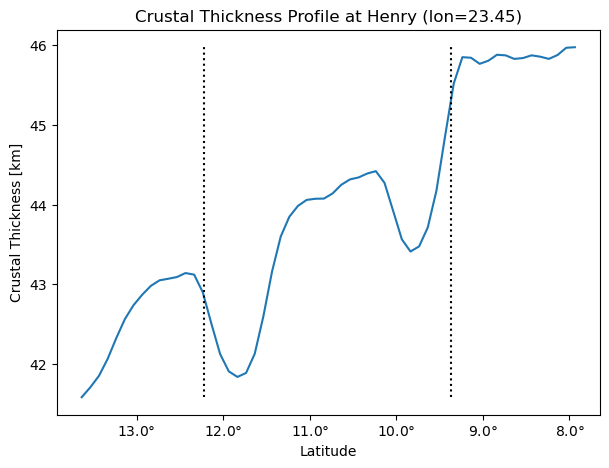

In [21]:
plot_craterCrThick_crossSection(Craters_170.getByName('Henry'), 2, 0.1)

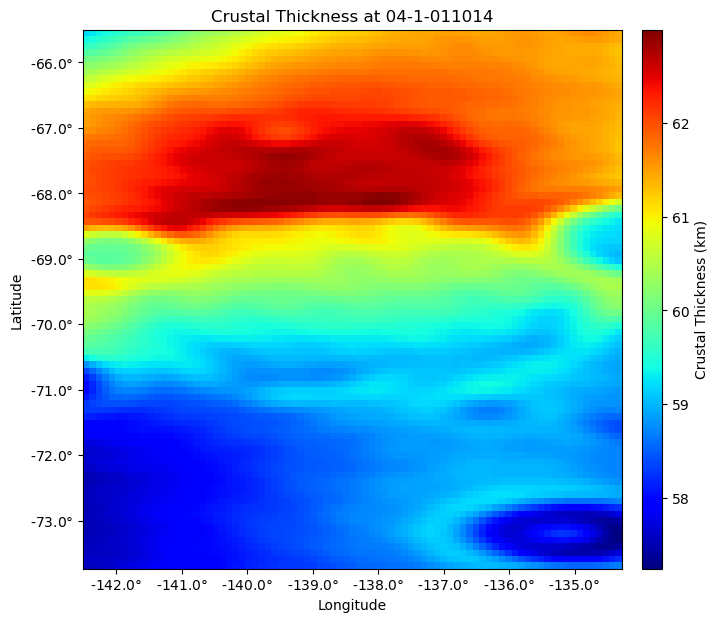

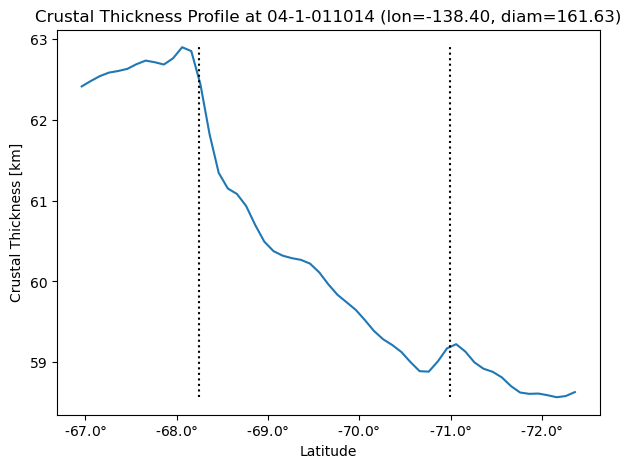

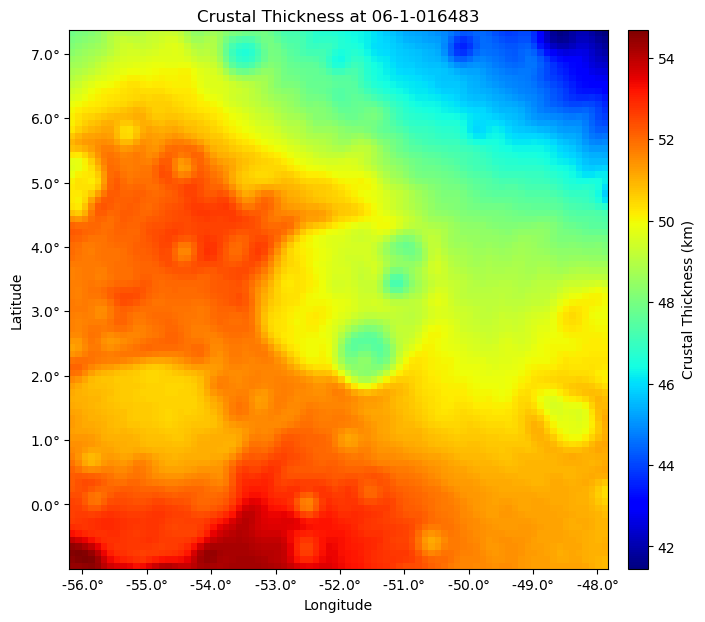

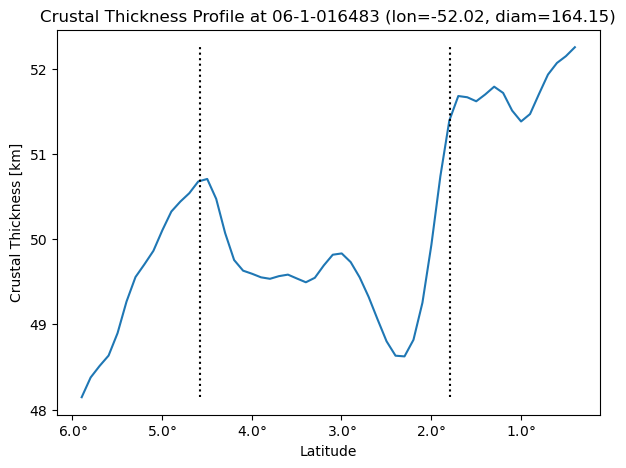

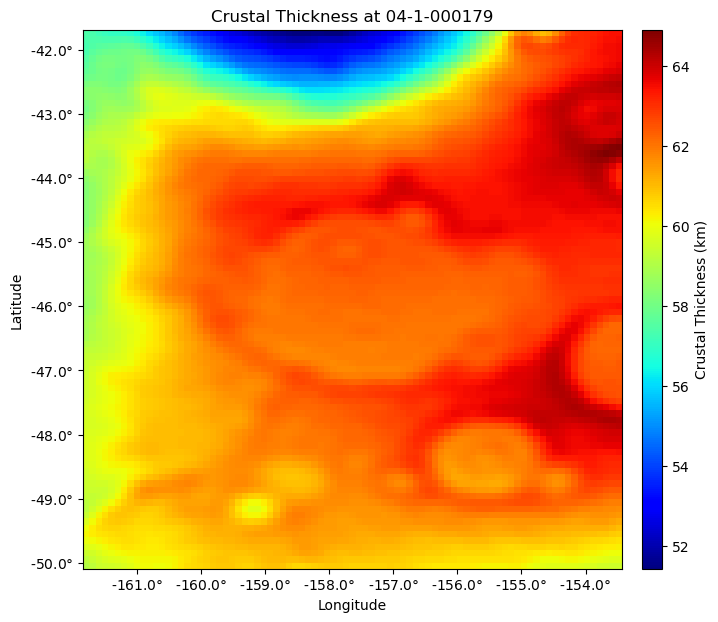

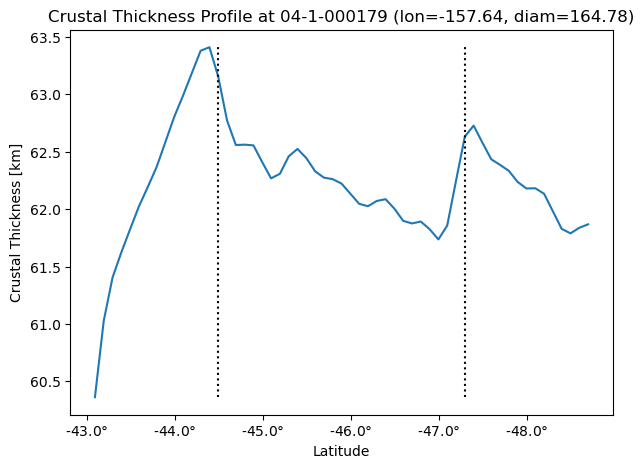

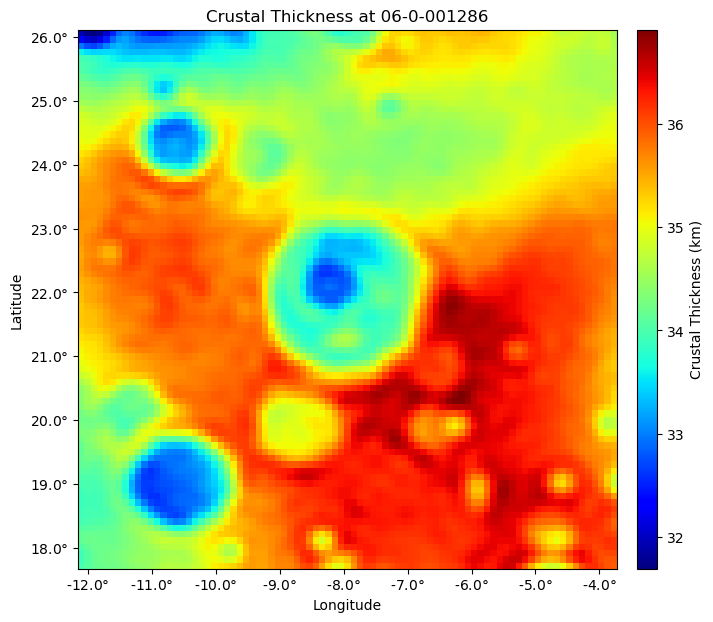

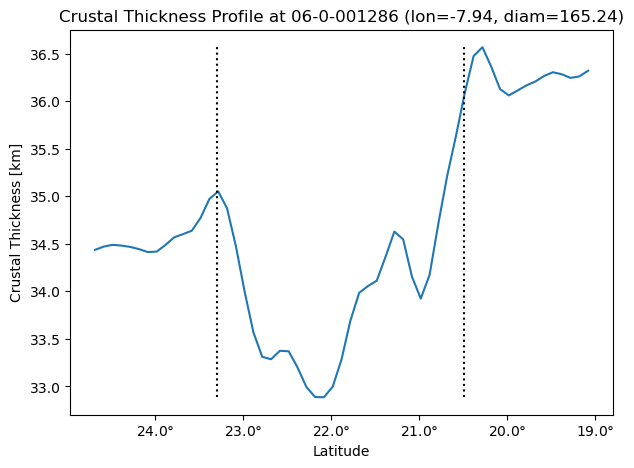

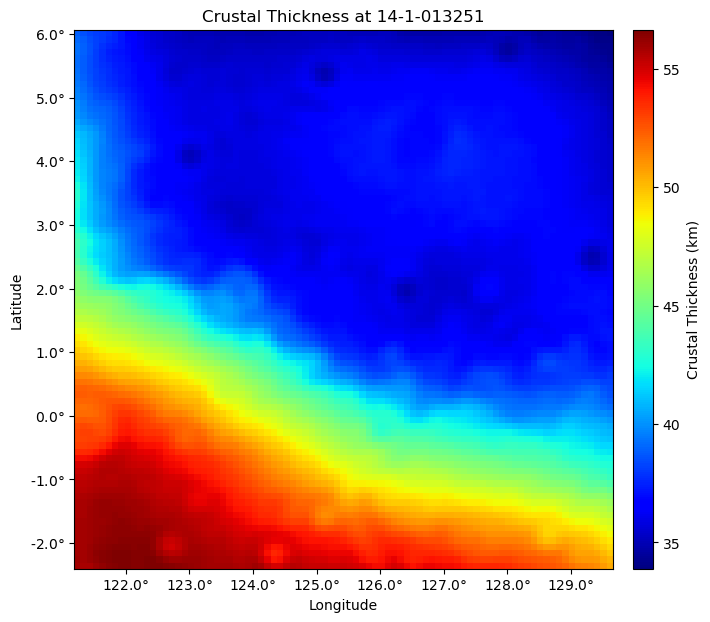

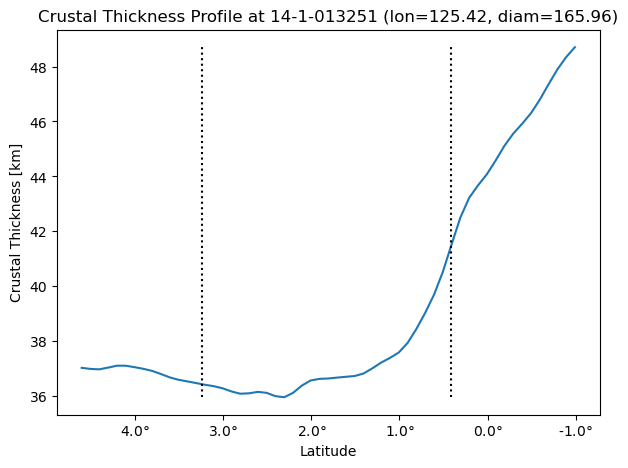

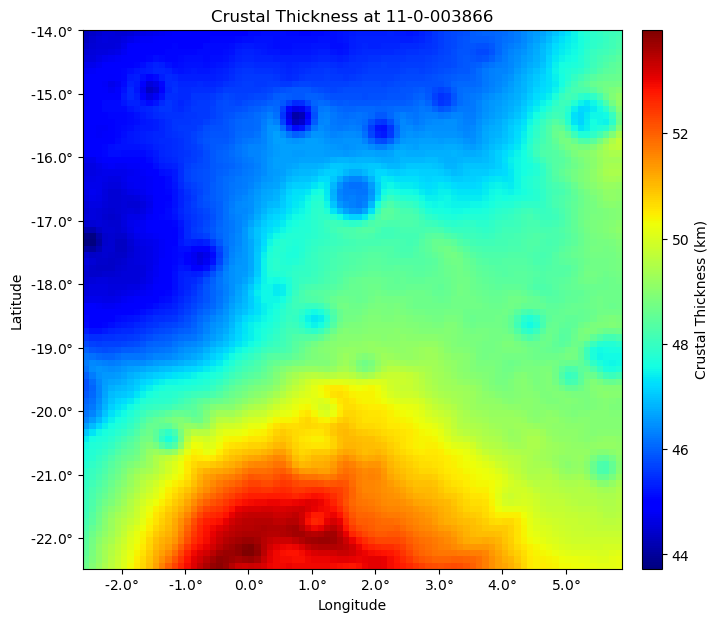

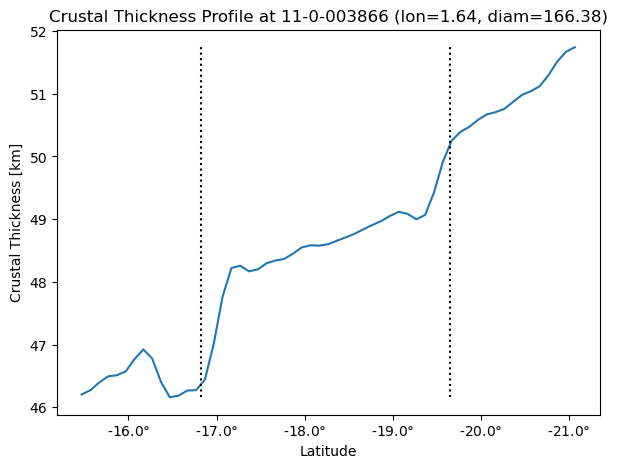

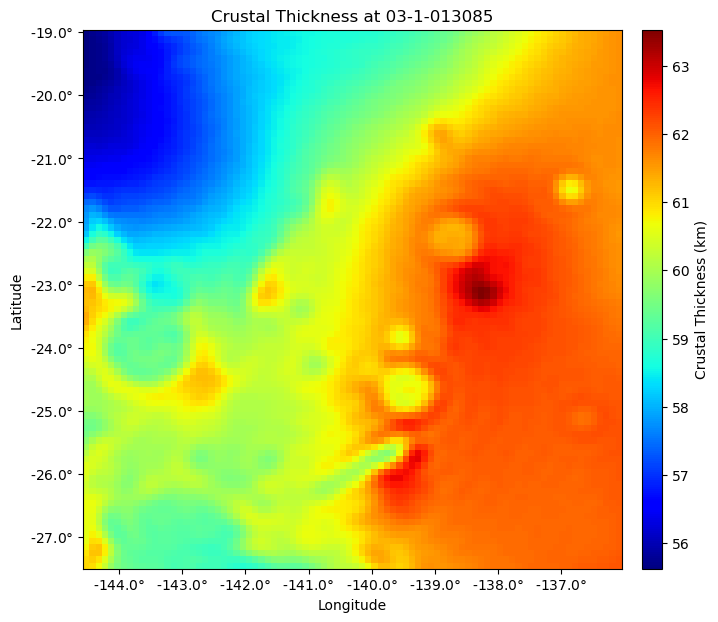

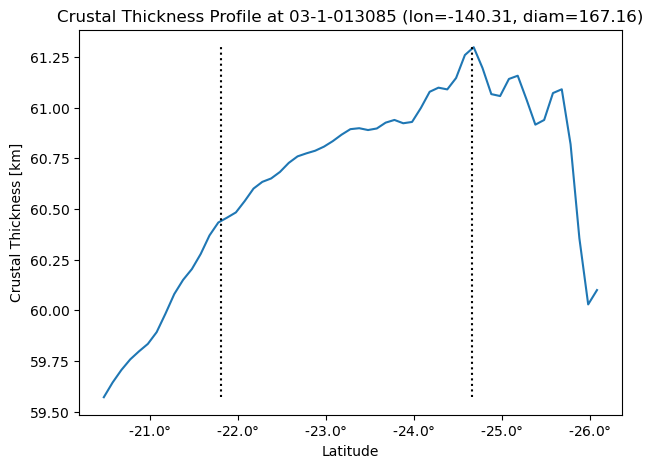

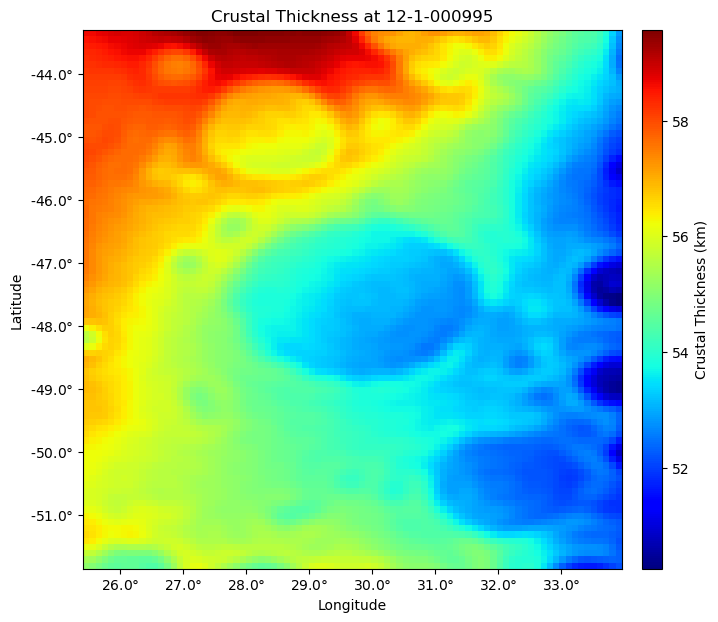

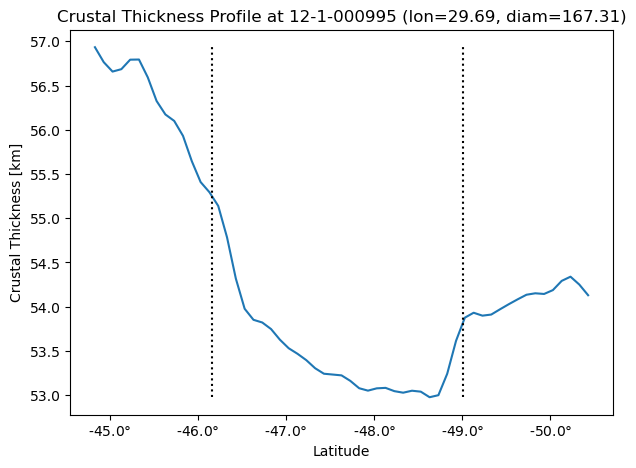

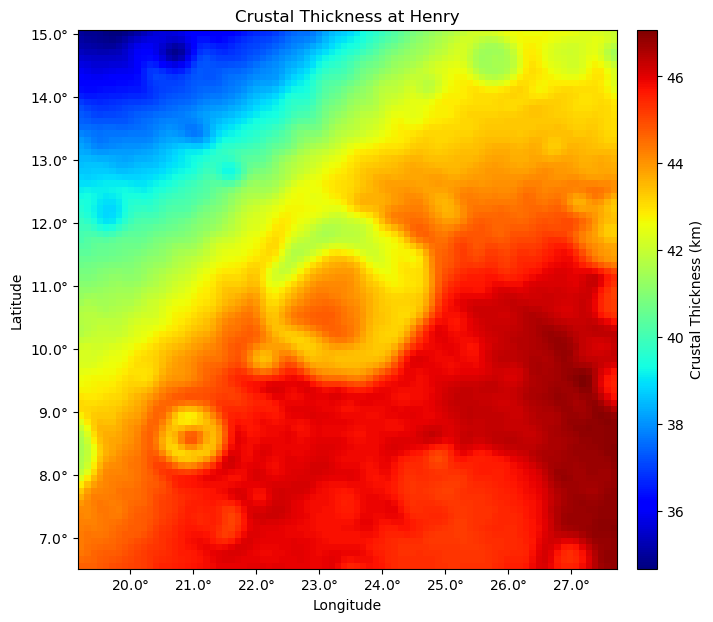

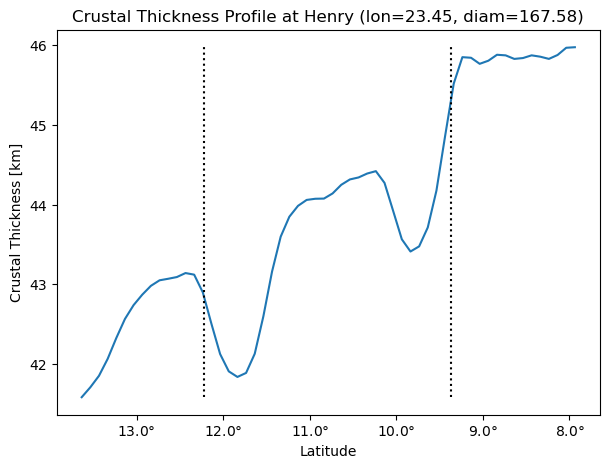

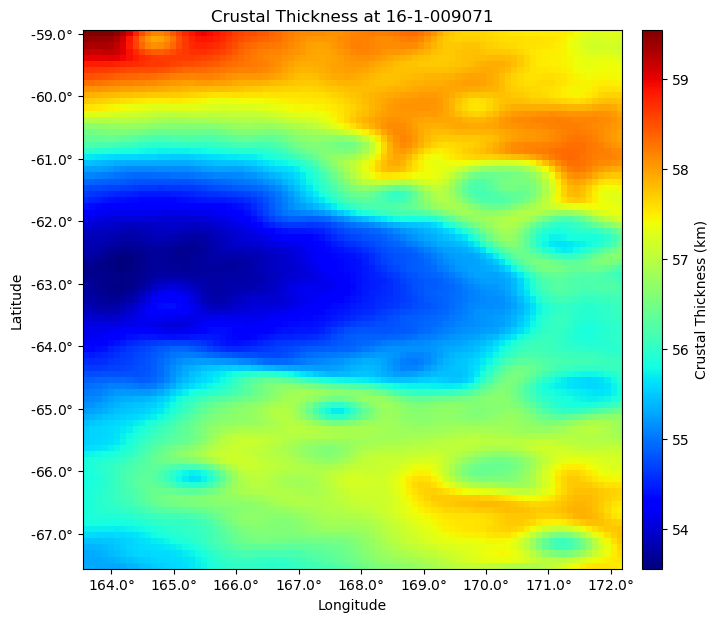

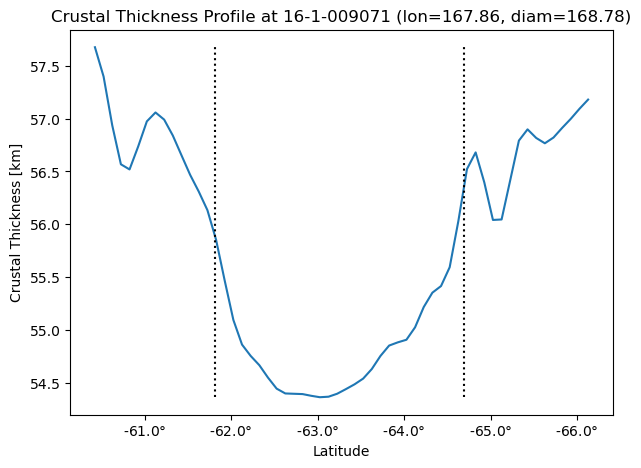

In [88]:
for i in range(10):
    # print(f'{i} -------------------------------\n')
    thisID = Craters_170.getData().iloc[i].to_dict()['id']
    plot_craterCrThick_2D(thisID, 3, 0.1)
    plot_craterCrThick_crossSection(Craters_170.getByID(thisID), 2, 0.1)